# Experiments to detect heteroskedasticity

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from random import randint as rand
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import euclidean_distances

from scipy.linalg import svd

from SeqPy.container.data_container import DataContainer
from seqpyplot.parsers.config_parser import config_parser
from pathlib import Path

from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 10)

pd.options.mode.chained_assignment = None 

ModuleNotFoundError: No module named 'seqpyplot'












# Helper functions

# Detect Heteroskedasticity

In [9]:
config = '../examples/example_config.ini'
config_obj = config_parser(config)

In [10]:
config_obj

In [11]:
container_obj.file_pairs

[('D1_Cont', 'D1_Treat'), ('D2_Cont', 'D2_Treat'), ('D3_Cont', 'D3_Treat')]

In [43]:
# load the data container_obj
container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()
data = container_obj.normalize_file_pairs(data) # Single df of normalized data

In [44]:
cols = data.columns
cols

Index(['D1_Cont', 'D2_Cont', 'D3_Cont', 'D1_Treat', 'D2_Treat', 'D3_Treat'], dtype='object')

In [96]:
df = data[['D3_Cont', 'D3_Treat']]
df.loc[:, 'mean'] = df.mean(axis=1)

In [97]:
d1 = df[['D3_Cont', 'mean']]
d2 = df[['D3_Treat', 'mean']]

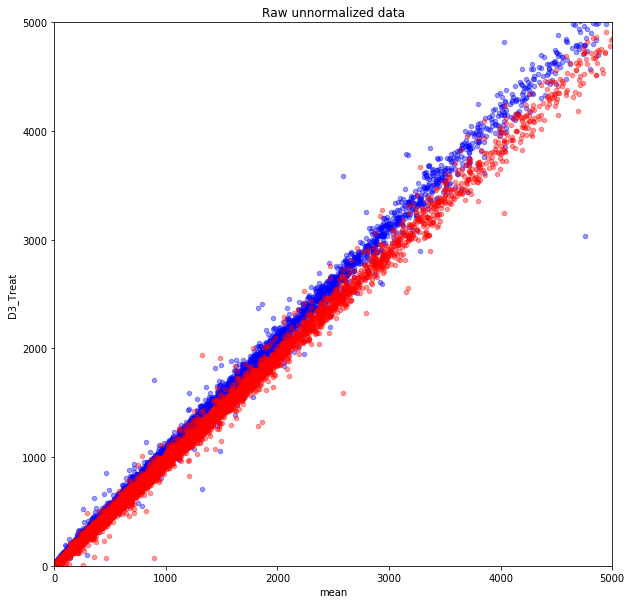

In [98]:
fig, ax = plt.subplots()
d1.plot('mean', 'D3_Cont', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='blue', alpha=0.4)
d2.plot('mean', 'D3_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
ax.set_title("Raw unnormalized data");

No handles with labels found to put in legend.


[[1.09646016]] [-1.66985095]
[[0.91183697]] [5.21303275]


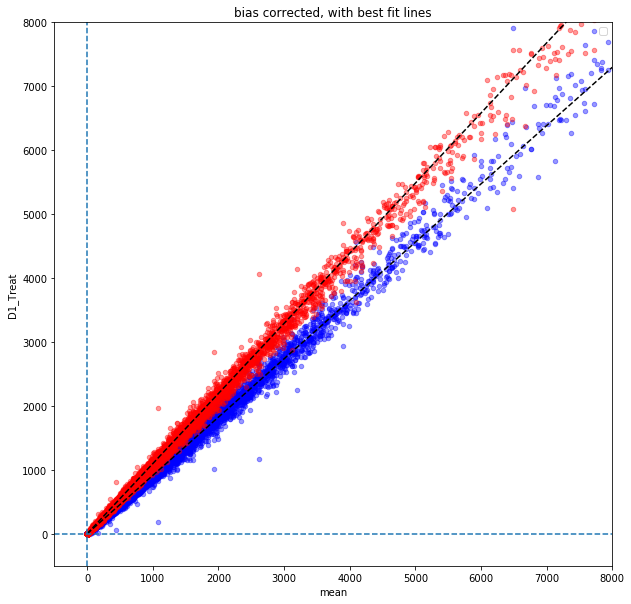

In [48]:
# Quick reset for this cell
d1 = df[['D1_Cont', 'mean']]
d2 = df[['D1_Treat', 'mean']]

# define regression objects
regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

# fit regression
regCont.fit(d1['D1_Cont'].values.reshape(-1, 1), d1['mean'].values.reshape(-1, 1))
regTreat.fit(d2['D1_Treat'].values.reshape(-1, 1), d1['mean'].values.reshape(-1, 1))

print(regCont.coef_, regCont.intercept_)
print(regTreat.coef_, regTreat.intercept_)

# Correct bias
d1['D1_Cont'] = d1['D1_Cont'] - regCont.intercept_
d2['D1_Treat'] = d2['D1_Treat'] - regTreat.intercept_

# Plot regression lines
fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', ax=ax, color='blue', alpha=0.4)
d2.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 8000), ylim=(0, 8000), ax=ax, color='red',  alpha=0.4)
plt.plot([0, 8000], [0.0, regCont.coef_ * 8000], linestyle='--', color='black')
plt.plot([0, 8000], [0.0, regTreat.coef_ * 8000], linestyle='--', color='black');
ax.set_title("bias corrected, with best fit lines");

plt.ylim((-500, 8000))
plt.xlim((-500, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

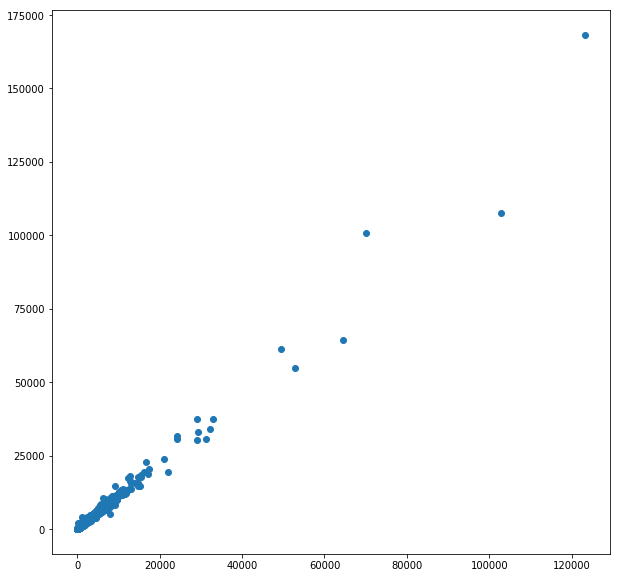

In [49]:
plt.scatter(d1['D1_Cont'], d2['D1_Treat'])

(0, 2500)

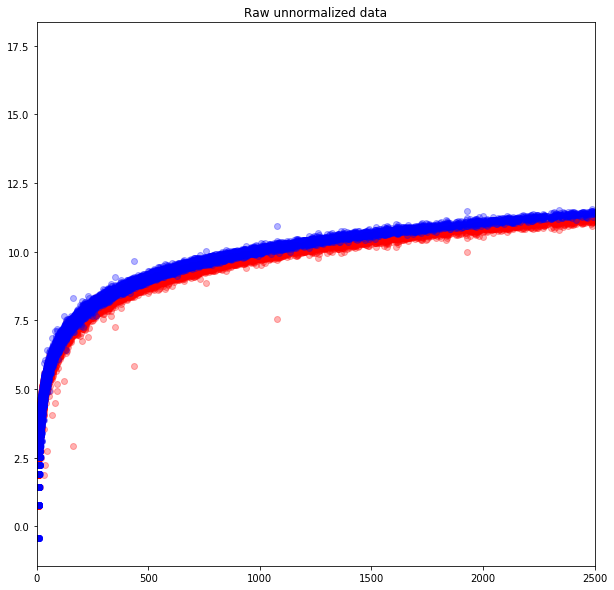

In [51]:
fig, ax = plt.subplots()
x1 = d1['mean']
y1 = d1['D1_Cont'].apply(lambda x: np.log2(x))
x2 = d2['mean']
y2 = d2['D1_Treat'].apply(lambda x: np.log2(x))

ax.scatter(x1, y1, c='red', alpha=0.3)
ax.scatter(x2, y2, c='blue', alpha=0.3)
ax.set_title("Raw unnormalized data");
ax.set_xlim((0, 2500))

In [53]:
container_obj.file_pairs

[('D1_Cont', 'D1_Treat'), ('D2_Cont', 'D2_Treat'), ('D3_Cont', 'D3_Treat')]

In [58]:
# results = list()
# for pair in container_obj.file_pairs:
#     df = data[list(pair)]
#     mean = df.mean(axis=1)
#     df = df.sub(mean)
#     results.append(df)

centeral all control observations on zero

In [120]:
results = list()
for pair in container_obj.file_pairs:
    df = data[list(pair)]
    df = df.apply(lambda x: x - df[df.columns[0]])
    results.append(df)
dat = pd.concat(results, axis=1)
dat = dat[[x[1] for x in container_obj.file_pairs]]

In [127]:
dat.loc[:, 'std'] = dat.std(axis=1)

In [128]:
dat.head()

,D1_Treat,D2_Treat,D3_Treat,std
gene,,,,
0610005C13Rik,13.743831,-2.832119,-3.893247,9.890691
0610007P14Rik,27.891812,62.189405,-24.912972,43.877660
0610009B22Rik,68.121425,24.014577,12.939429,29.192252
0610009L18Rik,4.786526,-22.801595,-2.839870,14.246267
0610009O20Rik,118.126123,173.379152,-18.884659,98.986720


In [119]:
dat.loc['Mir6957']

D1_Treat    0.0
D2_Treat    0.0
D3_Treat    0.0
std         0.0
Name: Mir6957, dtype: float64

In [145]:
with open('dataout.txt', 'w+') as outfile:
    for i in top_std_genes:
        outfile.write(str(i) + '\n')

In [139]:
dat.sort_values(by=['std'], ascending=False)['std'].std()

595.4595733396428

In [144]:
top_std_genes = dat[dat.sort_values(by=['std'], ascending=False)['std'] >  dat.sort_values(by=['std'], ascending=False)['std'].std()].sort_values(by=['std'], ascending=False).index

/Users/pgradie/miniconda-3.9.1/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [146]:
len(top_std_genes)

835

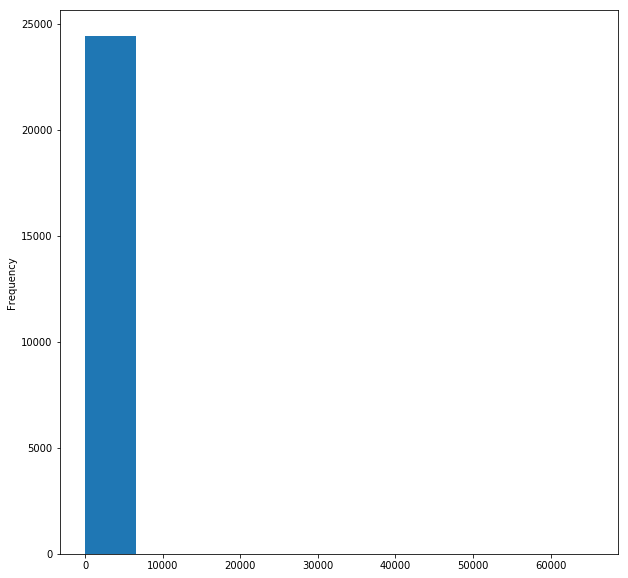

In [117]:
dat['std'].plot(kind='hist')

In [89]:
np.random.randint(0, 100, 20).std()

26.298811760229775

In [ ]:
dat

In [103]:
dat.head(20).std(axis=1
                 
                )

gene
0610005C13Rik     6.385317
0610007P14Rik    30.193757
0610009B22Rik    26.625237
0610009L18Rik     9.781619
0610009O20Rik    79.979674
0610010B08Rik     1.159945
0610010F05Rik    96.921546
0610010K14Rik    37.660123
0610011F06Rik    19.747589
0610012G03Rik    38.916708
0610030E20Rik    36.409759
0610031O16Rik     0.408248
0610037L13Rik    16.739981
0610038B21Rik     7.402650
0610039H22Rik     4.405756
0610039K10Rik     2.726548
0610040B10Rik     2.397858
0610040F04Rik     0.517091
0610040J01Rik     5.854774
0610043K17Rik     5.055931
dtype: float64